# **BANK BTN - PRADYTHA GALUH 2304220013**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("/content/DATA BBTN13.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
ts = df['Close']

**Uji Stasioner**

In [3]:
print("\n[ADF TEST]")
adf_result = adfuller(ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


[ADF TEST]
ADF Statistic: -2.7105395489129855
p-value: 0.07223215650687992


In [4]:
if adf_result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    d = 1
    print("Data di-differencing (d=1).")
else:
    ts_diff = ts
    d = 0
    print("Data sudah stasioner (d=0).")

Data di-differencing (d=1).


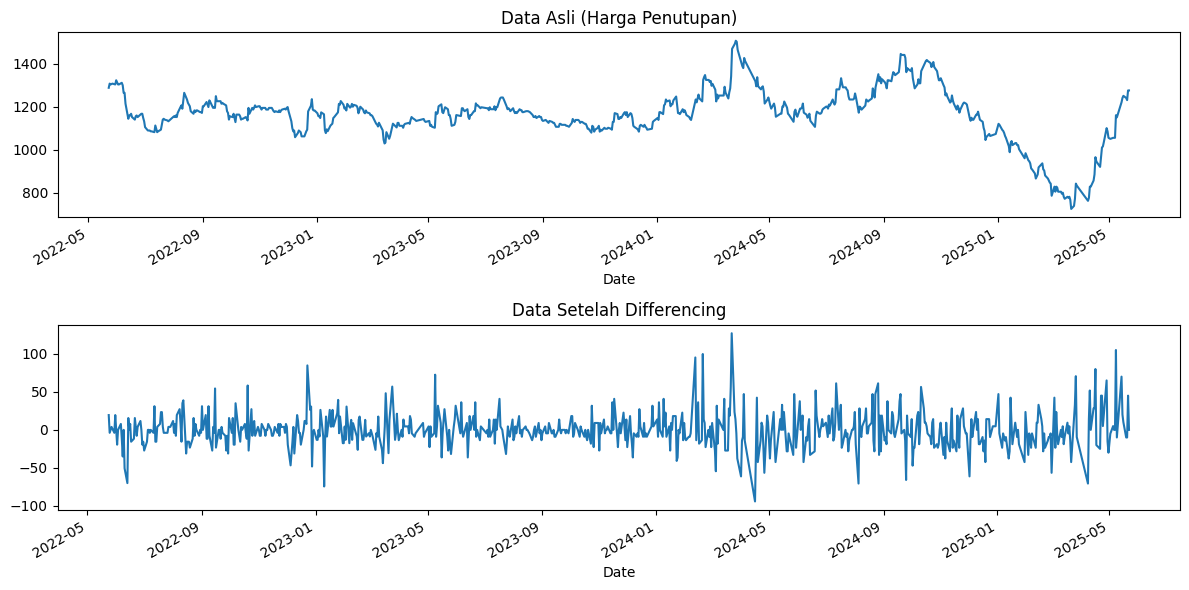

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
ts.plot(ax=axes[0], title="Data Asli (Harga Penutupan)")
ts_diff.plot(ax=axes[1], title="Data Setelah Differencing" if d > 0 else "Data Stasioner")
plt.tight_layout()
plt.show()

In [8]:
print("\n[GRID SEARCH AIC]")
p = q = range(0, 4)
aic_results = []
orders = []

for i, order in enumerate(itertools.product(p, q)):
    try:
        model = ARIMA(ts, order=(order[0], d, order[1]))
        result = model.fit()
        aic = result.aic
        print(f"ARIMA({order[0]},{d},{order[1]}) AIC={aic:.2f}")
        aic_results.append(aic)
        orders.append((order[0], d, order[1]))
    except:
        continue

min_aic_index = np.argmin(aic_results)
best_order = orders[min_aic_index]
print(f"\n✅ Best ARIMA order: {best_order} with AIC: {aic_results[min_aic_index]:.2f}")



[GRID SEARCH AIC]
ARIMA(0,1,0) AIC=6549.39
ARIMA(0,1,1) AIC=6549.30
ARIMA(0,1,2) AIC=6549.69
ARIMA(0,1,3) AIC=6550.38
ARIMA(1,1,0) AIC=6549.50
ARIMA(1,1,1) AIC=6546.97
ARIMA(1,1,2) AIC=6548.92
ARIMA(1,1,3) AIC=6550.83
ARIMA(2,1,0) AIC=6549.98
ARIMA(2,1,1) AIC=6552.93
ARIMA(2,1,2) AIC=6550.92
ARIMA(2,1,3) AIC=6549.70
ARIMA(3,1,0) AIC=6550.46
ARIMA(3,1,1) AIC=6552.40
ARIMA(3,1,2) AIC=6550.25
ARIMA(3,1,3) AIC=6550.26

✅ Best ARIMA order: (1, 1, 1) with AIC: 6546.97


In [9]:
model = ARIMA(ts, order=best_order)
results = model.fit()
print("\n[MODEL SUMMARY]")
print(results.summary())


[MODEL SUMMARY]
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3270.486
Date:                Mon, 09 Jun 2025   AIC                           6546.972
Time:                        15:18:50   BIC                           6560.706
Sample:                             0   HQIC                          6552.275
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8292      0.103     -8.045      0.000      -1.031      -0.627
ma.L1          0.8823      0.084     10.452      0.000       0.717       1.048
sigma2       522.8847     17.689   

**PLOT ACF DAN PACF**

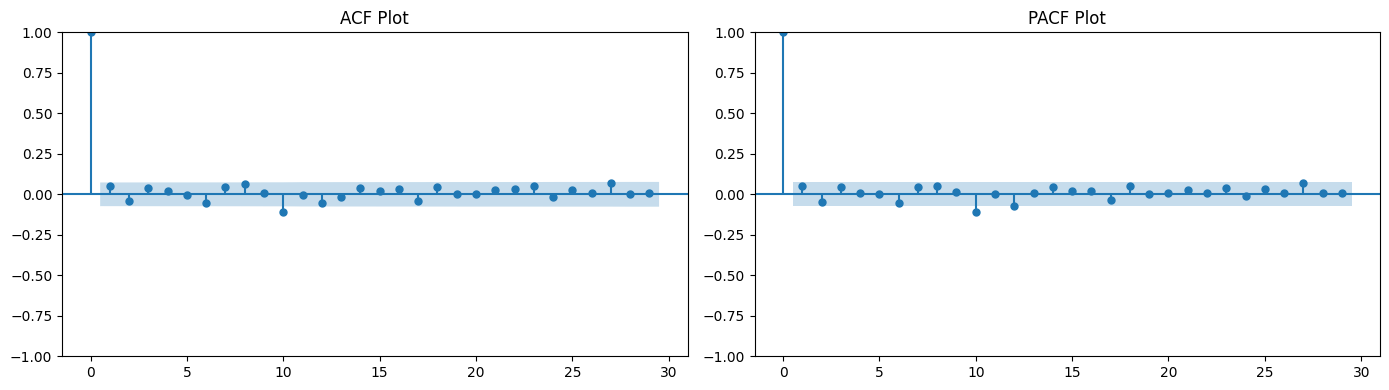

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

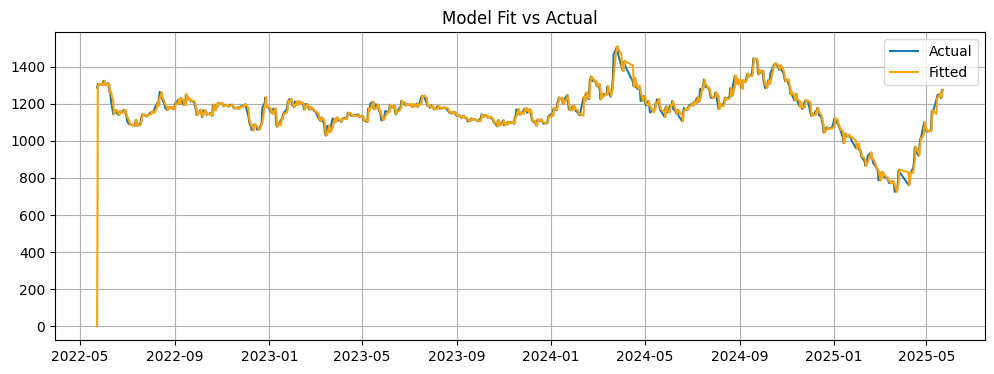

In [13]:
fitted = results.fittedvalues
plt.figure(figsize=(12, 4))
plt.plot(ts, label='Actual')
plt.plot(fitted, label='Fitted', color='orange')
plt.title("Model Fit vs Actual")
plt.legend()
plt.grid()
plt.show()

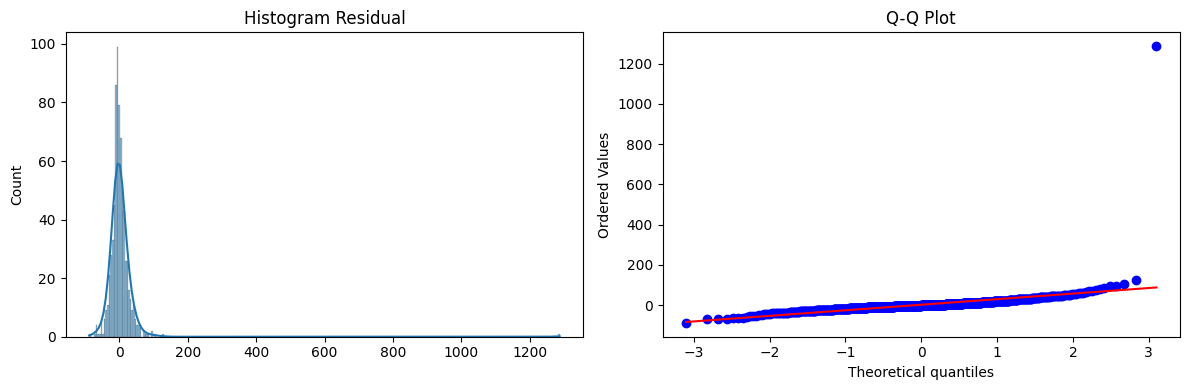


[UJI ASUMSI]
Ljung-Box p-value: 0.9961187197439956
Shapiro-Wilk p-value (normalitas): 3.3201300303358902e-46


In [15]:
resid = results.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(resid, kde=True, ax=ax[0])
from scipy import stats
stats.probplot(resid, dist="norm", plot=ax[1])
ax[0].set_title("Histogram Residual")
ax[1].set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

print("\n[UJI ASUMSI]")
print("Ljung-Box p-value:", acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].values[0])
print("Shapiro-Wilk p-value (normalitas):", shapiro(resid).pvalue)

In [16]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

model = ARIMA(train, order=best_order)
fit = model.fit()
forecast = fit.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\n[EVALUASI MODEL]")
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)


[EVALUASI MODEL]
MAE: 255.7774939948044
MSE: 92849.90898279613
MAPE: nan


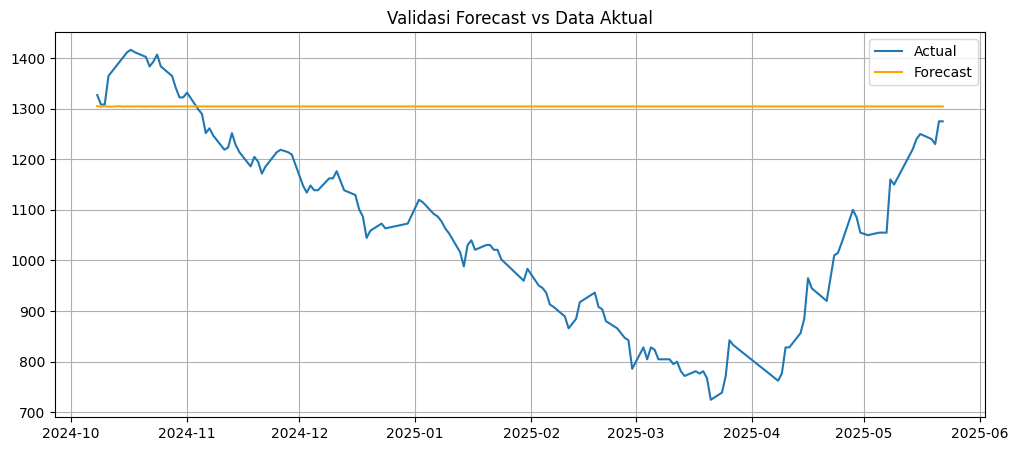

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.legend()
plt.title("Validasi Forecast vs Data Aktual")
plt.grid()
plt.show()

**FORECAST KE DEPAN**

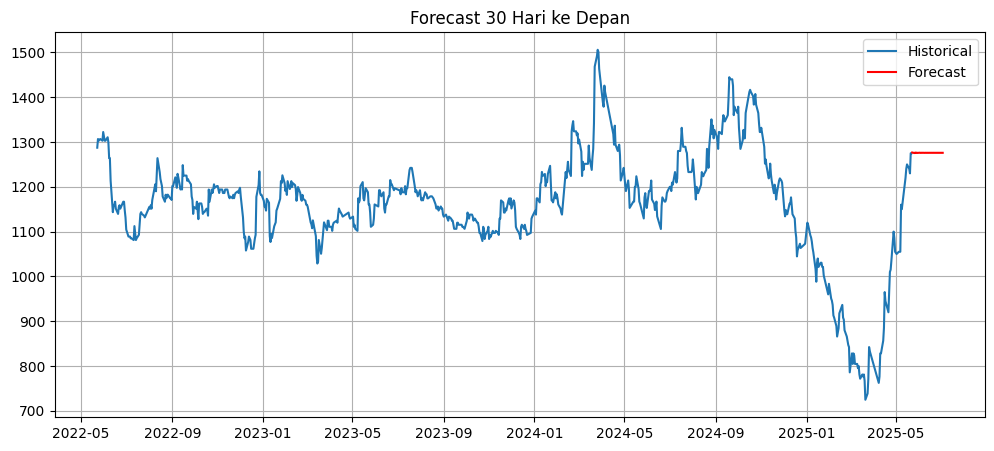

In [18]:
n_forecast = 30
future_forecast = results.forecast(steps=n_forecast)
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=n_forecast + 1, freq='B')[1:], future_forecast, label='Forecast', color='red')
plt.legend()
plt.title("Forecast 30 Hari ke Depan")
plt.grid()
plt.show()